<a href="https://colab.research.google.com/github/Shubhangam11/Double-Descent-Research/blob/master/DoubleDescentr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%cd /content/drive/My Drive/noisy_label_understanding_utilizing-master

/content/drive/My Drive/noisy_label_understanding_utilizing-master/data


In [0]:
test_e = {}
test_err={}
train_err={}
t_loss={}

In [0]:
#from my_model import create_model
from keras.callbacks import Callback, LearningRateScheduler
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import multi_gpu_model
from sklearn.metrics import accuracy_score
import data
import numpy as np
import os

#os.environ['CUDA_VISIBLE_DEVICES']='1'

import argparse
#parser = argparse.ArgumentParser()
#parser.add_argument('--noise_ratio',type=float)
#parser.add_argument('--noise_pattern',type=str)
#args = parser.parse_args()

""" parameters """
noise_ratio = 0#args.noise_ratio
noise_pattern = 'sym'#args.noise_pattern #'sym' or 'asym'
batch_size = 128
epochs = 50
save_dir = 'Theory'
network = 'ResNet20'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir,network+'.h5')
print('\n#######################################\n noise_ratio: %.2f noise_pattern: %s\n#######################################\n'
      %(noise_ratio,noise_pattern))

#################################################################################################################################
""" Data preparation """
x_train, y_train, _, _, x_test, y_test = data.prepare_cifar10_data(data_dir='/content/drive/My Drive/noisy_label_understanding_utilizing-master/data/cifar-10-batches-py')#data/cifar-10-batches-py')
y_train_noisy = data.flip_label(y_train, pattern=noise_pattern, ratio=noise_ratio, one_hot=True)
input_shape = list(x_train.shape[1:])
n_classes = y_train.shape[1]
n_train = x_train.shape[0]
np.save('y_train_total.npy',y_train)
np.save('y_train_noisy_total.npy',y_train_noisy)
clean_index = np.array([(y_train_noisy[i,:]==y_train[i,:]).all() for i in range(n_train)])# For tracking only, unused during training
noisy_index = np.array([not i for i in clean_index])

# Generator for data augmantation
datagen = ImageDataGenerator(width_shift_range=4./32,  # randomly shift images horizontally (fraction of total width)
                             height_shift_range=4./32,  # randomly shift images vertically (fraction of total height)
                             horizontal_flip=True
                             )  # randomly flip images    



#################################################################################################################################
""" Build model """

val_idx = np.array([True for i in range(n_train)])
val_idx_int = np.array([i for i in range(n_train) if val_idx[i]]) # integer index
np.random.shuffle(val_idx_int)
n_val_tenth = int(np.sum(val_idx)/10)
val1_idx = val_idx_int[:n_val_tenth] # integer index
val2_idx = val_idx_int[n_val_tenth:] # integer index

#checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=False)

class Noisy_acc(Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        
        idx = val2_idx[np.random.choice(len(val2_idx),1000)] # train on the first half while test on the second half 
        
        predict = self.model.predict(x_train[idx,:])
        predict = np.argmax(predict,axis=1)
        _acc_mix = accuracy_score(np.argmax(y_train_noisy[idx,:],axis=1), predict)
        _acc_clean = accuracy_score(np.argmax(y_train_noisy[idx,:][clean_index[idx],:],axis=1), predict[clean_index[idx]])
        _acc_noisy = accuracy_score(np.argmax(y_train_noisy[idx,:][noisy_index[idx],:],axis=1), predict[noisy_index[idx]])

        print("- acc_mix: %.4f - acc_clean: %.4f - acc_noisy: %.4f\n" % (_acc_mix, _acc_clean, _acc_noisy))
        return
noisy_acc = Noisy_acc()

def lr_schedule(epoch):
    # Learning Rate Schedule
    lr = 1e-3
    #if epoch > 180:
     #   lr *= 0.5e-3
    #elif epoch > 160:
     #   lr *= 1e-3
   # elif epoch > 120:
    #    lr *= 1e-2
    #elif epoch > 100:
     #   lr *= 1e-1
    print('Learning rate: ', lr)
    return lr
lr_callback = LearningRateScheduler(lr_schedule)


# Define optimizer and compile model
optimizer = optimizers.Adam(lr_schedule(0))#, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


for s in range(1,64):
  model = create_model(input_shape=input_shape, classes=n_classes, name=network,k=s, architecture=network)
  model.summary()

#parallel_model = multi_gpu_model(model, gpus=2)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics = ['accuracy'])


##################################################################################################################################

  results = model.fit_generator(datagen.flow(x_train[val1_idx,:], y_train_noisy[val1_idx,:], batch_size = batch_size),
                               epochs = epochs,
                               validation_data=(x_train[val2_idx,:], y_train_noisy[val2_idx,:]),
                               callbacks=[noisy_acc, lr_callback])


  rr=[]
  for t in results.history['val_accuracy']:
    rr.append(1-t)
  test_err7[s]=rr
  rs=[] 
  for t in results.history['accuracy']:
    rs.append(1-t) 
    train_err[s]=rs
  
  rl=[] 
  for t in results.history['loss']: 
  rl.append(1-t) 
  t_loss[s]=rl

  scores = model.evaluate(x_test, y_test, verbose=1)
  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1])
  test_e[s] = 1 - scores[1]


  y_pred = np.argmax(model.predict(x_train[val2_idx,:]), axis=1)
  y_true_noisy = np.argmax(y_train_noisy[val2_idx,:],axis=1)
  select_idx =  val2_idx[y_pred==y_true_noisy]# integer index
  print('Noisy Validation Accuracy: %.4f'%(len(select_idx)/len(y_pred)))
  print('Label Precision: %.4f'%(np.sum(clean_index[select_idx])/len(select_idx)))
  print('Label Recall: %.4f'%(np.sum(clean_index[select_idx])/np.sum(clean_index[val2_idx])))

  y_test_pred = np.argmax(model.predict(x_test), axis=1)
  np.save(save_dir+'/y_pred_'+noise_pattern+str(noise_ratio)+'.npy',y_pred)
  np.save(save_dir+'/y_true_'+noise_pattern+str(noise_ratio)+'.npy',np.argmax(y_train[val2_idx,:], axis=1))
  np.save(save_dir+'/y_test_pred_'+noise_pattern+str(noise_ratio)+'.npy',y_test_pred)
  np.save(save_dir+'/y_test_true_'+noise_pattern+str(noise_ratio)+'.npy',np.argmax(y_test, axis=1))
  print('Noise ratio: %.2f'%noise_ratio)

  model.save(filepath)


In [0]:
#ten_test={}
for k,v in enumerate(arr):
  ten_test[v] = test_e[v]
print(ten_test)

In [0]:
for t in results.history['val_accuracy']:
  test_err5.append(1-t)

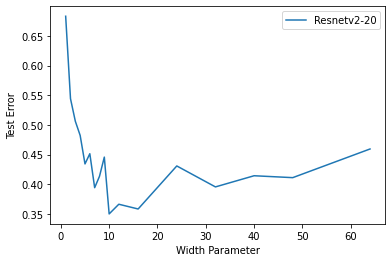

In [0]:
tr =sorted(ten_test.items())
x10,y10 = zip(*tr)
plt.plot(x10,y10,label='Resnetv2-20')
  
plt.xlabel('Width Parameter')
plt.ylabel('Test Error')
plt.legend(loc='upper right')

In [0]:

import keras
from keras.layers import Input,Conv2D,Dense,BatchNormalization,Activation,add,GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.layers import AveragePooling2D, Flatten
from keras.models import Model
from keras.regularizers import l2
# ResNet building block of two layers
def building_block(X, filter_size, filters, stride=1):

    # Save the input value for shortcut
    X_shortcut = X

    # Reshape shortcut for later adding if dimensions change
    #if stride > 1:
    if stride > 1 or filters>X.get_shape()[-1]:

        X_shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_regularizer=l2(1e-4))(X_shortcut)
        X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    # First layer of the block
    X = Conv2D(filters, kernel_size = filter_size, strides=stride, padding='same', kernel_regularizer=l2(1e-4))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second layer of the block
    X = Conv2D(filters, kernel_size = filter_size, strides=(1, 1), padding='same', kernel_regularizer=l2(1e-4))(X)
    X = BatchNormalization(axis=3)(X)
    X = add([X, X_shortcut])  # Add shortcut value to main path
    X = Activation('relu')(X)

    return X


# Full model
def create_model(input_shape, classes, name,k, architecture='ResNet32'):

    # Define the input
    X_input = Input(input_shape)

    if architecture == 'ResNet32':
        # Stage 1
        X = Conv2D(filters=16, kernel_size=3, strides=(1, 1), padding='same')(X_input)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)
    
        # Stage 2
        X = building_block(X, filter_size=3, filters=16, stride=1)
        X = building_block(X, filter_size=3, filters=16, stride=1)
        X = building_block(X, filter_size=3, filters=16, stride=1)
        X = building_block(X, filter_size=3, filters=16, stride=1)
        X = building_block(X, filter_size=3, filters=16, stride=1)
    
        # Stage 3
        X = building_block(X, filter_size=3, filters=32, stride=2)  # dimensions change (stride=2)
        X = building_block(X, filter_size=3, filters=32, stride=1)
        X = building_block(X, filter_size=3, filters=32, stride=1)
        X = building_block(X, filter_size=3, filters=32, stride=1)
        X = building_block(X, filter_size=3, filters=32, stride=1)
    
        # Stage 4
        X = building_block(X, filter_size=3, filters=64, stride=2)  # dimensions change (stride=2)
        X = building_block(X, filter_size=3, filters=64, stride=1)
        X = building_block(X, filter_size=3, filters=64, stride=1)
        X = building_block(X, filter_size=3, filters=64, stride=1)
        X = building_block(X, filter_size=3, filters=64, stride=1)
    
        # Average pooling and output layer
        X = GlobalAveragePooling2D()(X) 
        X = Dense(classes, activation='softmax')(X)
        
    elif architecture == 'WRN-28-10':
        
        # Stage 1
        X = Conv2D(filters=16, kernel_size=3, strides=(1, 1), padding='same')(X_input)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)

        # Stage 2
        for i in range(9):
            X = building_block(X, filter_size=3, filters=160, stride=1)

        # Stage 3
        X = building_block(X, filter_size=3, filters=320, stride=2)  # dimensions change (stride=2)
        for i in range(1,9):
            X = building_block(X, filter_size=3, filters=320, stride=1)

        # Stage 4
        X = building_block(X, filter_size=3, filters=640, stride=2)  # dimensions change (stride=2)
        for i in range(1,9):
            X = building_block(X, filter_size=3, filters=640, stride=1)        
        
        # Average pooling and output layer
        X = GlobalAveragePooling2D()(X)
        X = Dense(classes, activation='softmax')(X)
    
    elif architecture == 'ResNet110':
        return resnet_v2(input_shape, depth=110, num_classes=classes)
    elif architecture == 'ResNet20':
      return resnet_v2(input_shape,k, depth=20, num_classes=classes)
    
    elif architecture == 'ResNet164':
        return resnet_v2(input_shape, depth=164, num_classes=classes)
        
    elif architecture == 'CNN9':        
        X = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', kernel_regularizer=l2(1e-4))(X_input)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)
        X = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', kernel_regularizer=l2(1e-4))(X)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)
        X = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', kernel_regularizer=l2(1e-4))(X)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)
        X = GlobalMaxPooling2D()(X)
        
        X = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same', kernel_regularizer=l2(1e-4))(X)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)
        X = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same', kernel_regularizer=l2(1e-4))(X)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)
        X = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same', kernel_regularizer=l2(1e-4))(X)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)
        X = GlobalMaxPooling2D()(X)
        
        X = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same', kernel_regularizer=l2(1e-4))(X)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)
        X = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same', kernel_regularizer=l2(1e-4))(X)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)
        X = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', kernel_regularizer=l2(1e-4))(X)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)

        # Average pooling and output layer
        X = GlobalAveragePooling2D()(X)
        X = Dense(classes, activation='softmax')(X)
        

    # Create model
    model = Model(inputs=X_input, outputs=X, name=name)

    return model

In [0]:

# borrow from https://github.com/keras-team/keras/blob/master/examples/cifar10_resnet.py
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  #kernel_regularizer=l2(1e-4)
                  )


    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

def resnet_v2(input_shape,k, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = k
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

**Retired Work**

In [0]:



#th_dict=[]
tes=[]
ite =2
for ind,val in enumerate(results.history['val_accuracy']):
  th_dict[ite] = val
  te.append(1-val)
  if ind== 100:
    ite+=1
plt.plot(th,label='Resnetv2-20 Width Parameter-64')
plt.xlim([0,100])
plt.xlabel('Epoch')
plt.ylabel('Test Error')
plt.legend(loc='upper right')

In [0]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
x=[]
x1=[]
y1=[]
y=[]
x2=[]
y2=[]
#for i,v in enumerate(test_err6):
 # x2.append(i+1)
  #y2.append(v)
#for i,v in enumerate(test_err5):
 # x.append(i+1)
  #y.append(v)
for i,v in test_e.items():
  x1.append(i)
  y1.append(v)
#yhat = scipy.signal.savgol_filter(y, 21, 1)
yhat1 = scipy.signal.savgol_filter(yq, 9, 2)
#yhat2 = scipy.signal.savgol_filter(y2, 11, 1)
#th_dict=[]
#te=[]
#ite =1
#for ind,val in enumerate(results.history['val_accuracy']):
 # th_dict[ite] = val
  #te.append(1-val)
  #if ind== 100:
   # ite+=1
plt.plot(xq,yhat1,label='Resnetv2-20  Noise Ratio:0')
#plt.plot(x,yhat1,label='Resnetv2-20 Parameter Width= 16')
#plt.plot(x,yhat,label='Resnetv2-20 Parameter Width= 64')
#plt.annotate('Interpolation Threshold', xy=(75,0.474), xytext=(75, 0.5),
 #            arrowprops=dict(facecolor='black', shrink=0.05),
  #           )
plt.xlim([0,64])
plt.xlabel('Epoch')
plt.ylabel('Test Error')
plt.legend(loc='upper right')


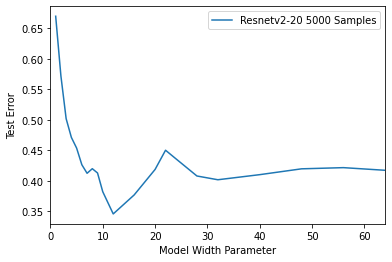

In [0]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
x=[]
x1=[]
y1=[]
y=[]
x2=[]
y2=[]
#for i,v in enumerate(test_err6):
 # x2.append(i+1)
  #y2.append(v)
#for i,v in enumerate(test_err5):
 # x.append(i+1)
  #y.append(v)
for i,v in tent.items():
  x1.append(i)
  y1.append(v)
#yhat = scipy.signal.savgol_filter(y, 21, 1)
yhat1 = scipy.signal.savgol_filter(yt, 5, 2)
#yhat2 = scipy.signal.savgol_filter(yq, 5, 3)
#th_dict=[]
#te=[]
fig, ax = plt.subplots()
#ite =1
#for ind,val in enumerate(results.history['val_accuracy']):
 # th_dict[ite] = val
  #te.append(1-val)
  #if ind== 100:
   # ite+=1
#plt.plot(ks, errs, label='Test Error')
#ax.axvspan(21, 28, alpha=0.5, color='Red')
plt.plot(xt,yhat1,label='Resnetv2-20 5000 Samples')
#plt.plot(xq,yhat2,label='Resnetv2-20 25000 Samples')

#plt.plot(x,yhat,label='Resnetv2-20 Parameter Width= 64')
#plt.annotate('Interpolation Threshold', xy=(28,0.3), xytext=(28, 0.35),
 #            arrowprops=dict(facecolor='black', shrink=0.05),
  #           )
plt.xlim([0,64])
plt.xlabel('Model Width Parameter')
plt.ylabel('Test Error')
plt.legend(loc='upper right')


In [0]:
sum_dict[1]=yy
sum_dict[2]=test_err1

In [0]:
sd=[]
for i in range(0,99):
  sd.append((yy[i]+test_err1[i])/10)


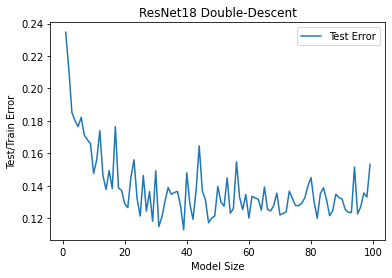

In [0]:
errs = np.array(sd)

p = 0.2 # fraction of noise
errs = 1.0 - (1-p)*(1-errs) + errs*p/9 # remap clean test error --> noisy test error.

stds = np.std(errs, axis=0)
mean = np.mean(errs, axis=0)
#train_err = np.mean([M['Train Error'][:, -1] for M in Ms], axis=0)

ks=np.array([M for M in range(1,100)])
fig, ax = plt.subplots()
ax.plot(ks,sd , label='Test Error')
#ax.plot(ks, train_err, label='Train Error')
#ax.fill_between(ks, mean-stds, mean+stds ,alpha=0.3)
ax.set_xlabel("Model Size")
ax.set_ylabel("Test/Train Error")
ax.set_title("ResNet18 Double-Descent")
ax.legend()

In [0]:
from sklearn.datasets import fetch_openml
from sklearn.utils import check_random_state

from sklearn.model_selection import train_test_split

In [0]:
X, y = fetch_openml(data_id=40926, return_X_y=True)


In [0]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


In [0]:
test_loss={}

In [0]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
x=[]
x1=[]
y1=[]
y=[]
x2=[]
y2=[]
#for i,v in enumerate(test_err6):
 # x2.append(i+1)
  #y2.append(v)
#for i,v in enumerate(test_err5):
 # x.append(i+1)
  #y.append(v)
for i,v in tent.items():
  x1.append(i)
  y1.append(v)
#yhat = scipy.signal.savgol_filter(y, 21, 1)
yhat1 = scipy.signal.savgol_filter(yt, 5, 2)
yhat2 = scipy.signal.savgol_filter(yq, 5, 3)
#th_dict=[]
#te=[]
fig, ax = plt.subplots()
#ite =1
#for ind,val in enumerate(results.history['val_accuracy']):
 # th_dict[ite] = val
  #te.append(1-val)
  #if ind== 100:
   # ite+=1
#plt.plot(ks, errs, label='Test Error')
ax.axvspan(21, 28, alpha=0.5, color='Red')
plt.plot(xt,yhat1,label='Resnetv2-20 5000 Samples')
plt.plot(xq,yhat2,label='Resnetv2-20 25000 Samples')

#plt.plot(x,yhat,label='Resnetv2-20 Parameter Width= 64')
#plt.annotate('Interpolation Threshold', xy=(28,0.3), xytext=(28, 0.35),
 #            arrowprops=dict(facecolor='black', shrink=0.05),
  #           )
plt.xlim([0,64])
plt.xlabel('Model Width Parameter')
plt.ylabel('Test Error')
plt.legend(loc='upper right')


In [0]:

test_error={}
te =[]


In [0]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, GaussianNoise
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 100
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 2

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#x_train=x_train[:12500]
#y_train=y_train[:12500]
#x_test=x_test[:2500]
#y_test=y_test[:2500]
#print(len(y_train))
#(x_train, y_train)=new_dataset[0.8:0.2]
#(x_test, y_test) =newtest_dataset
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

def add_noise_and_clip_data(data):
   noise = np.random.normal(loc=0.0, scale=0.4, size=data.shape)

   data = data + noise
   data = np.clip(data, 0., 1.)
   return data



# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean
#y_train = add_noise_and_clip_data(y_train)
#y_test = add_noise_and_clip_data(y_test)


print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
   # if epoch > 180:
    #    lr *= 0.5e-3
   # elif epoch > 160:
    #    lr *= 1e-3
    #elif epoch > 120:
    #    lr *= 1e-2
    #elif epoch > 100:
     #   lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal')
                  #kernel_regularizer=l2(5e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        x = GaussianNoise(2)(x)
        if batch_normalization:

            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(k,input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = k#16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)

    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(k,input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = k
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model
arr=[64]#1,8,16,24,32,40,48,54,64]
te=[]

for k in arr:
    if version == 2:
        model = resnet_v2(k,input_shape=input_shape, depth=depth)
    else:
        model = resnet_v1(k,input_shape=input_shape, depth=depth)

    model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
    model.summary()
  #print(model[k]_type)

# Prepare model model saving directory.
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
    checkpoint = ModelCheckpoint(filepath=filepath,
                               monitor='val_acc',
                               verbose=1,
                               save_best_only=True)
    lr_scheduler = LearningRateScheduler(lr_schedule)

    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

  
    callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
    if not data_augmentation:
        print('Not using data augmentation.')
        history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_test, y_test),
                shuffle=True,
                callbacks=callbacks)
    else:
        print('Using real-time data augmentation.')
      # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
          # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history= model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)
   

    for t in history.history['val_accuracy']:
        te.append(1-t)

    plt.plot(te, label = k)
    plt.xlim([0,epochs])
    plt.xlabel('Epoch')
    plt.ylabel('Test Error')
    plt.legend(loc='upper right')
  
# Score trained model.
    scores = model.evaluate(x_test, y_test, verbose=1)
    print('k Test loss:', scores[0])
    test_loss[k]=scores[0]
    print('k Test accuracy:', scores[1])
    test_error[k]=1-scores[1]

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
Learning rate:  0.001
Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1129 (Conv2D)            (None, 32, 32, 64)   1792        input_23[0][0]                   
__________________________________________________________________________________________________
gaussian_noise_10 (GaussianNois (None, 32, 32, 64)   0           conv2d_1129[0][0]                
__________________________________________________________________________________________________
batch_normalization_1064 (Batch (None, 32, 32, 64)   256         gaus

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


391/391 [==============================] - 93s 237ms/step - loss: 1.5675 - accuracy: 0.4245 - val_loss: 2.4197 - val_accuracy: 0.2765
Epoch 3/100
Learning rate:  0.001
391/391 [==============================] - 93s 237ms/step - loss: 1.4005 - accuracy: 0.4897 - val_loss: 1.8985 - val_accuracy: 0.4116
Epoch 4/100
Learning rate:  0.001
391/391 [==============================] - 93s 237ms/step - loss: 1.2686 - accuracy: 0.5418 - val_loss: 1.7521 - val_accuracy: 0.5014
Epoch 5/100
Learning rate:  0.001
391/391 [==============================] - 93s 238ms/step - loss: 1.1539 - accuracy: 0.5861 - val_loss: 1.6040 - val_accuracy: 0.5144
Epoch 6/100
Learning rate:  0.001
391/391 [==============================] - 93s 238ms/step - loss: 1.0515 - accuracy: 0.6249 - val_loss: 1.1777 - val_accuracy: 0.6058
Epoch 7/100
Learning rate:  0.001
391/391 [==============================] - 93s 238ms/step - loss: 0.9637 - accuracy: 0.6572 - val_loss: 1.2038 - val_accuracy: 0.6374
Epoch 8/100
Learning rate:

No handles with labels found to put in legend.


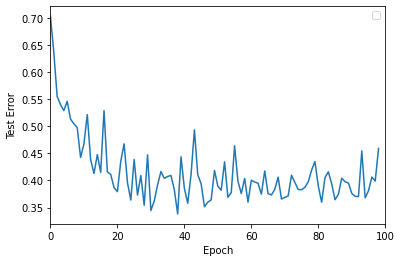

In [0]:
plt.plot(sd)
plt.xlim([0,epochs])
plt.xlabel('Epoch')
plt.ylabel('Test Error')
plt.legend(loc='upper right')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/10
1563/1563 [==============================] - 29s 19ms/step - loss: 1.8204 - accuracy: 0.3371 - val_loss: 1.6325 - val_accuracy: 0.4203
Epoch 2/10
1563/1563 [==============================] - 29s 19ms/step - loss: 1.5338 - accuracy: 0.4462 - val_loss: 1.3288 - val_accuracy: 0.5225
Epoch 3/10
1563/1563 [==============================] - 29s 18ms/step - loss: 1.4092 - accuracy: 0.4969 - val_loss: 1.2707 - val_accuracy: 0.5534
Epoch 4/10
1563/1563 [==============================] - 29s 18ms/step - loss: 1.3138 - accuracy: 0.5328 - val_loss: 1.1547 - val_accuracy: 0.5903
Epoch 5/10
1563/1563 [==============================] - 29s 18ms/step - loss: 1.2373 - accuracy: 0.5589 - val_loss: 1.0961 - val_accuracy: 0.6141
Epoch 6/10
1563/1563 [==============================] - 30s 19ms/step - loss: 1.1789 - accuracy: 0.5855 - val_loss: 1.0956 - val_accuracy: 0.6121
Epoch 7/10
1563/

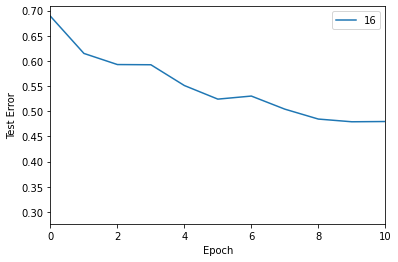

In [0]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 10
epochs = 10
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)
te1=[]
for t in history.history['val_accuracy']:
        te1.append(1-t)

plt.plot(te1, label = k)
plt.xlim([0,epochs])
plt.xlabel('Epoch')
plt.ylabel('Test Error')
plt.legend(loc='upper right')

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])



In [0]:
te

In [0]:
history= model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)
   

for t in history.history['val_accuracy']:
        te.append(1-t)

plt.plot(te, label = k)
plt.xlim([0,epochs])
plt.xlabel('Epoch')
plt.ylabel('Test Error')
plt.legend(loc='upper right')
  
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('k Test loss:', scores[0])
test_loss[k]=scores[0]
print('k Test accuracy:', scores[1])
test_error[k]=1-scores[1]

Epoch 1/100
Learning rate:  0.001
391/391 [==============================] - 90s 230ms/step - loss: 0.0489 - accuracy: 0.9829 - val_loss: 1.4799 - val_accuracy: 0.7563
Epoch 2/100
Learning rate:  0.001


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


391/391 [==============================] - 90s 230ms/step - loss: 0.0564 - accuracy: 0.9803 - val_loss: 1.6999 - val_accuracy: 0.7471
Epoch 3/100
Learning rate:  0.001
391/391 [==============================] - 90s 230ms/step - loss: 0.0548 - accuracy: 0.9810 - val_loss: 1.5569 - val_accuracy: 0.7561
Epoch 4/100
Learning rate:  0.001
391/391 [==============================] - 90s 229ms/step - loss: 0.0536 - accuracy: 0.9811 - val_loss: 1.7073 - val_accuracy: 0.7431
Epoch 5/100
Learning rate:  0.001
391/391 [==============================] - 90s 230ms/step - loss: 0.0526 - accuracy: 0.9817 - val_loss: 1.4797 - val_accuracy: 0.7533
Epoch 6/100
Learning rate:  0.001
391/391 [==============================] - 90s 230ms/step - loss: 0.0504 - accuracy: 0.9832 - val_loss: 1.5149 - val_accuracy: 0.7562
Epoch 7/100
Learning rate:  0.001
391/391 [==============================] - 90s 230ms/step - loss: 0.0644 - accuracy: 0.9772 - val_loss: 1.5238 - val_accuracy: 0.7586
Epoch 8/100
Learning rate:

KeyboardInterrupt: ignored

In [0]:

for x in arr:
  re[x] = te
re

NameError: ignored

In [0]:
te

[0.6087000072002411,
 0.6371000111103058,
 0.561599999666214,
 0.453499972820282,
 0.4556000232696533,
 0.4383999705314636,
 0.4301999807357788,
 0.42570000886917114,
 0.4697999954223633,
 0.3928999900817871,
 0.3708999752998352,
 0.3733999729156494,
 0.3587999939918518,
 0.3758999705314636,
 0.3758000135421753,
 0.3514999747276306,
 0.3496999740600586,
 0.3174999952316284,
 0.30809998512268066,
 0.343500018119812,
 0.3363000154495239,
 0.2889999747276306,
 0.2912999987602234,
 0.3317999839782715,
 0.3223000168800354,
 0.3288000226020813,
 0.2955999970436096,
 0.2929999828338623,
 0.27170002460479736,
 0.32520002126693726,
 0.28039997816085815,
 0.29409998655319214,
 0.2955999970436096,
 0.2840999960899353,
 0.27560001611709595,
 0.292900025844574,
 0.2831000089645386,
 0.27160000801086426,
 0.27069997787475586,
 0.26260000467300415,
 0.2784000039100647,
 0.2906000018119812,
 0.26319998502731323,
 0.267300009727478,
 0.2523000240325928,
 0.2605000138282776,
 0.2937999963760376,
 0.2689

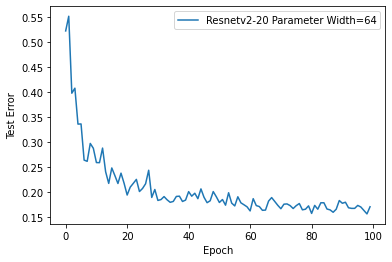

In [0]:
#test_l =sorted(re.items())
#x, y=zip(*((int(x), k) for k in re for x in re[k]))
index=[64]#,8,16,24,32,64]
for val in index:
  plt.plot(re[val],label='Resnetv2-20 Parameter Width=64')
  
  plt.xlabel('Epoch')
  plt.ylabel('Test Error')
  plt.legend(loc='upper right')

In [0]:
re


{1: [0.7765000015497208,
  0.8394999951124191,
  0.8355000019073486,
  0.7064999938011169,
  0.6861000061035156,
  0.8131999969482422,
  0.6491999924182892,
  0.6739999949932098,
  0.6301999986171722,
  0.611299991607666,
  0.6265000104904175,
  0.7032000124454498,
  0.6689999997615814,
  0.6538000106811523,
  0.615200012922287,
  0.6297000050544739,
  0.699999988079071,
  0.7488000094890594,
  0.7098000049591064,
  0.6913999915122986,
  0.7375999987125397,
  0.7530999928712845,
  0.5934999883174896,
  0.8402000069618225,
  0.6207999885082245,
  0.6922000050544739,
  0.7378000020980835,
  0.6608999967575073,
  0.5945999920368195,
  0.7989999949932098,
  0.8706000000238419,
  0.5992000102996826,
  0.7892999947071075,
  0.5624000132083893,
  0.845100000500679,
  0.6213000118732452,
  0.567799985408783,
  0.7871000021696091,
  0.5356999933719635,
  0.6328999996185303,
  0.6218999922275543,
  0.6976999938488007,
  0.7037999927997589,
  0.5487000048160553,
  0.546999990940094,
  0.549600005

In [0]:
train_error={1:0.5186,
             2:0.6356,
             8:0.8833,
             11:0.9029,
             12:09201,
             13:0.9219,
             32:0.9768,
             64:0.9842}
train_l =sorted(train_error.items())
x1,y1 = zip(*train_l)
plt.plot(x1,y1,label='Resnetv2')
  
plt.xlabel('Width Parameter')
plt.ylabel('Train Error')
plt.legend(loc='upper right')

SyntaxError: ignored

In [0]:
test_l =sorted(test_error.items())
x,y = zip(*test_l)
plt.plot(x,y,label='Resnetv2')
  
plt.xlabel('Width Parameter')
plt.ylabel('Test Error')
plt.legend(loc='upper right')

In [0]:
test_error[3]= 1-0.705299973487854

In [0]:
test_error[8]=0.2055000066757202